# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

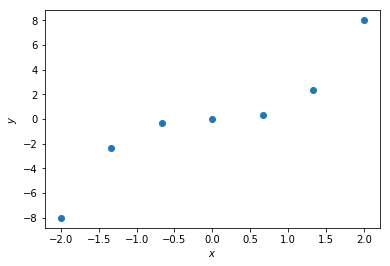

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

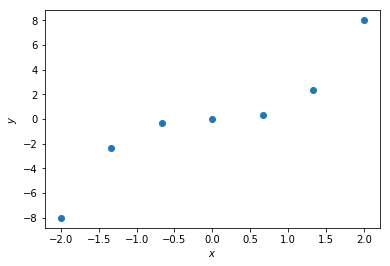

In [3]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

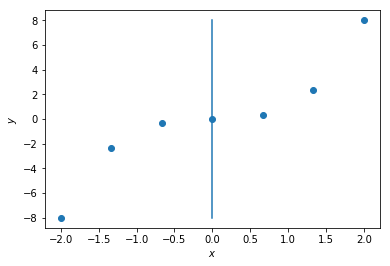

In [4]:
X2 = np.zeros(len(X))

plt.scatter(X, y)
plt.plot(X2, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [5]:
def Q(X, y, t):
    mas=np.zeros(len(t))
    for i in range(0, len(t)):
        Xleft=[x for x in X if x<t[i]]
        yleft=y[:len(Xleft)]
        Xright=[x for x in X if x>=t[i]]
        yright=y[len(Xleft):]
        mas[i] = D(X, y) - len(Xleft)/len(X)*D(Xleft, yleft)-len(Xright)/len(X)*D(Xright, yright)
    
    return mas

def D(X, y):
    s = 0
    for j in range(0, len(X)):
        s=s+(y[j]-(1/len(X))*sum(X))**2
    return s/len(X)

def regression_var_criterion(X, y, t):
    q = Q(X, y, t)
    
    return q

t = np.arange(-1.9, 1.9, 0.1)
q = regression_var_criterion(X, y, t)

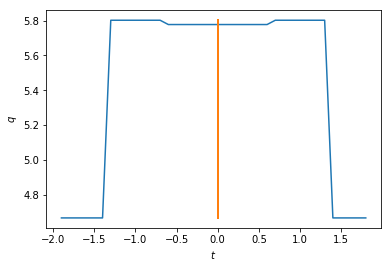

In [6]:
X3 = np.zeros(len(t))

plt.plot(t, q)
plt.plot(X3, q)
plt.xlabel(r'$t$')
plt.ylabel(r'$q$');

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Я думаю, значение порога t=0 выглядит оптимально,так как на графике видно что слева и справа части "разрезаного" графика одинаковые. 

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

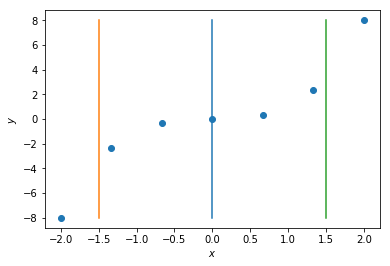

In [7]:
x1 = np.zeros(len(y))
x2=np.array([-1.5 for yy in y])
x3=np.array([1.5 for yy in y])

plt.scatter(X, y)
plt.plot(x1, y, x2, y, x3, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

Откровенно говоря, не понимаю откуда у них такие цифры. Скорее всего я что-то сделала не так и просто неправильно построила график(хотя количество листьев совпадает). Но у меня только три отрезка вышло.

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [8]:
df = pd.read_csv('mlbootcamp5_train.csv', index_col='id', sep=';')

In [9]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [10]:
df['age'] = round(df['age']/365)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,50.0,2,168,62.0,110,80,1,1,0,0,1,0
1,55.0,1,156,85.0,140,90,3,1,0,0,1,1
2,52.0,1,165,64.0,130,70,3,1,0,0,0,1
3,48.0,2,169,82.0,150,100,1,1,0,0,1,1
4,48.0,1,156,56.0,100,60,1,1,0,0,0,0


In [11]:
for i in df['cholesterol'].unique():
    df['cholesterol'+'='+str(i)] = df['cholesterol']==i
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,cholesterol=1,cholesterol=3,cholesterol=2
id,,,,,,,,,,,,,,,
0,50.0,2,168,62.0,110,80,1,1,0,0,1,0,True,False,False
1,55.0,1,156,85.0,140,90,3,1,0,0,1,1,False,True,False
2,52.0,1,165,64.0,130,70,3,1,0,0,0,1,False,True,False
3,48.0,2,169,82.0,150,100,1,1,0,0,1,1,True,False,False
4,48.0,1,156,56.0,100,60,1,1,0,0,0,0,True,False,False


In [12]:
for i in df['gluc'].unique():
    df['gluc'+'='+str(i)] = df['gluc']==i
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,cholesterol=1,cholesterol=3,cholesterol=2,gluc=1,gluc=2,gluc=3
id,,,,,,,,,,,,,,,,,,
0,50.0,2,168,62.0,110,80,1,1,0,0,1,0,True,False,False,True,False,False
1,55.0,1,156,85.0,140,90,3,1,0,0,1,1,False,True,False,True,False,False
2,52.0,1,165,64.0,130,70,3,1,0,0,0,1,False,True,False,True,False,False
3,48.0,2,169,82.0,150,100,1,1,0,0,1,1,True,False,False,True,False,False
4,48.0,1,156,56.0,100,60,1,1,0,0,0,0,True,False,False,True,False,False


In [13]:
df['cholesterol=1'] = df['cholesterol=1'].astype('int64')
df['cholesterol=2'] = df['cholesterol=2'].astype('int64')
df['cholesterol=3'] = df['cholesterol=3'].astype('int64')
df['gluc=1'] = df['gluc=1'].astype('int64')
df['gluc=2'] = df['gluc=2'].astype('int64')
df['gluc=3'] = df['gluc=3'].astype('int64')

df = df.drop(['gluc'], axis=1)
df = df.drop(['cholesterol'], axis=1)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol=1,cholesterol=3,cholesterol=2,gluc=1,gluc=2,gluc=3
id,,,,,,,,,,,,,,,,
0,50.0,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0
1,55.0,1,156,85.0,140,90,0,0,1,1,0,1,0,1,0,0
2,52.0,1,165,64.0,130,70,0,0,0,1,0,1,0,1,0,0
3,48.0,2,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0
4,48.0,1,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0


In [14]:
X = df.drop(['cardio'], axis=1)
y = df['cardio']

X.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cholesterol=1,cholesterol=3,cholesterol=2,gluc=1,gluc=2,gluc=3
id,,,,,,,,,,,,,,,
0,50.0,2,168,62.0,110,80,0,0,1,1,0,0,1,0,0
1,55.0,1,156,85.0,140,90,0,0,1,0,1,0,1,0,0
2,52.0,1,165,64.0,130,70,0,0,0,0,1,0,1,0,0
3,48.0,2,169,82.0,150,100,0,0,1,1,0,0,1,0,0
4,48.0,1,156,56.0,100,60,0,0,0,1,0,0,1,0,0


In [15]:
y.head()

id
0    0
1    1
2    1
3    1
4    0
Name: cardio, dtype: int64

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify = y, random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [17]:
clf_tree = DecisionTreeClassifier( max_depth=3, random_state=17)
clf_tree.fit(X_train, y_train)
export_graphviz(clf_tree, out_file='my_small_tree.dot', filled=True, feature_names=X.columns)

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

"ap_hi", "cholesterol=3", "age"

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [18]:
print(accuracy_score(y_test, clf_tree.predict(X_test)))

0.7259523809523809


Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [19]:
tree = DecisionTreeClassifier(random_state=17)
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree, tree_params,cv=5)
tree_grid.fit(X_train, y_train);

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

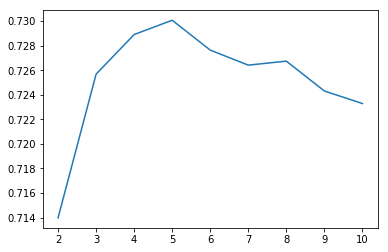

In [20]:
scores = tree_grid.cv_results_['mean_test_score']
plt.plot(list(range(2, 11)), scores);

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

Лучшее значение max_depth = 5, это видно из графика(думаю можно ничего не выводить)

In [21]:
print(accuracy_score(y_test, tree_grid.predict(X_test)))

0.7319523809523809


**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

1)Видно плохо,но думаю да,имеется

In [22]:
acc2 = accuracy_score(y_test, tree_grid.predict(X_test))
acc1 = accuracy_score(y_test, clf_tree.predict(X_test))

print((acc2 - acc1) / acc1 * 100)

0.8265004919645793


2)Нет,не повысила

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [23]:
for i in [45, 50, 60, 65]:
    df['age'+'='+str(i)] = df['age']==i

df['age=45'] = df['age=45'].astype('int64')
df['age=50'] = df['age=50'].astype('int64')
df['age=60'] = df['age=60'].astype('int64')
df['age=65'] = df['age=65'].astype('int64')

for i in [120, 140, 160, 180]:
    df['ap_hi'+'='+str(i)] = df['ap_hi']==i
    
df['ap_hi=120'] = df['ap_hi=120'].astype('int64')
df['ap_hi=140'] = df['ap_hi=140'].astype('int64')
df['ap_hi=160'] = df['ap_hi=160'].astype('int64')
df['ap_hi=180'] = df['ap_hi=180'].astype('int64')

df['male'] = df['gender']-1

df = df.drop(['gender'], axis=1)

In [24]:
use = ['cardio', 'smoke', 'cholesterol=1', 'cholesterol=2','cholesterol=3','age=45', 'age=50', 'age=60', 'age=65', 'ap_hi=120', 'ap_hi=140', 'ap_hi=160', 'ap_hi=180']

In [25]:
usingData = df[use]
usingData.head()

,cardio,smoke,cholesterol=1,cholesterol=2,cholesterol=3,age=45,age=50,age=60,age=65,ap_hi=120,ap_hi=140,ap_hi=160,ap_hi=180
id,,,,,,,,,,,,,
0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,1,0,0
2,1,0,0,0,1,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0


In [26]:
XX = usingData.drop(['cardio'], axis=1)
yy = usingData['cardio']

In [27]:
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=0.3,stratify = yy)
trrre = DecisionTreeClassifier( max_depth=3, random_state=17)
trrre.fit(XX_train, yy_train)
export_graphviz(trrre, out_file='my_small_trrre.dot', filled=True, feature_names=XX.columns)

Верхнее артериальное давление от 140 до 160 (мм рт.ст.)